In [1]:
import cv2
import numpy as np
from itertools import combinations_with_replacement
from collections import defaultdict
from numpy.linalg import inv
import matplotlib.pyplot as plt
from guided_filter_pytorch.guided_filter import FastGuidedFilter
import scipy as sp
from scipy.ndimage import zoom
from scipy.ndimage import minimum_filter, maximum_filter
from pathlib import Path
import os

# Hàm Phụ

In [2]:
def get_illumination_channel(I, w):
    # Apply minimum filter for dark channel
    darkch = minimum_filter(I, size=(w, w, 1), mode='nearest').min(axis=2)
    # Apply maximum filter for bright channel
    brightch = maximum_filter(I, size=(w, w, 1), mode='nearest').max(axis=2)

    return darkch, brightch

def get_atmosphere(I, brightch, p=0.1):
    M, N = brightch.shape
    flatI = I.reshape(M*N, 3) # reshaping image array
    flatbright = brightch.ravel() #flattening image array

    searchidx = (-flatbright).argsort()[:int(M*N*p)] # sorting and slicing
    A = np.mean(flatI.take(searchidx, axis=0), dtype=np.float64, axis=0)
    return A

def get_initial_transmission(A, brightch):
    A_c = np.max(A)
    init_t = (brightch-A_c)/(1.-A_c) # finding initial transmission map
    return (init_t - np.min(init_t))/(np.max(init_t) - np.min(init_t)) # normalized initial transmission map

def get_corrected_transmission(I, A, darkch, brightch, init_t, alpha, omega, w):
    im = I / A  # Vectorized division
    dark_c, _ = get_illumination_channel(im, w)  # dark channel transmission map
    dark_t = 1 - omega * dark_c  # corrected dark transmission map
    corrected_t = init_t.copy()  # initializing corrected transmission map with initial transmission map
    diffch = brightch - darkch  # difference between transmission maps

    # Vectorized update of corrected_t based on condition
    corrected_t = np.where(diffch < alpha, dark_t * init_t, corrected_t)

    return corrected_t

def box(img, r):
    """ O(1) box filter
        img - >= 2d image
        r   - radius of box filter
    """
    (rows, cols) = img.shape[:2]
    imDst = np.zeros_like(img)


    tile = [1] * img.ndim
    tile[0] = r
    imCum = np.cumsum(img, 0)
    imDst[0:r+1, :, ...] = imCum[r:2*r+1, :, ...]
    imDst[r+1:rows-r, :, ...] = imCum[2*r+1:rows, :, ...] - imCum[0:rows-2*r-1, :, ...]
    imDst[rows-r:rows, :, ...] = np.tile(imCum[rows-1:rows, :, ...], tile) - imCum[rows-2*r-1:rows-r-1, :, ...]

    tile = [1] * img.ndim
    tile[1] = r
    imCum = np.cumsum(imDst, 1)
    imDst[:, 0:r+1, ...] = imCum[:, r:2*r+1, ...]
    imDst[:, r+1:cols-r, ...] = imCum[:, 2*r+1 : cols, ...] - imCum[:, 0 : cols-2*r-1, ...]
    imDst[:, cols-r: cols, ...] = np.tile(imCum[:, cols-1:cols, ...], tile) - imCum[:, cols-2*r-1 : cols-r-1, ...]

    return imDst

def guided_filter(I, p, r, eps, s=None):
    if s is not None:
        I = zoom(I, [1/s, 1/s, 1], order=1)
        p = zoom(p, [1/s, 1/s], order=1)
        r = round(r / s)

    h, w = p.shape[:2]
    N = box(np.ones((h, w)), r)

    mI = box(I, r) / N[..., np.newaxis]
    mP = box(p, r) / N

    mIp = box(I * p[..., np.newaxis], r) / N[..., np.newaxis]

    covIp = mIp - mI * mP[..., np.newaxis]

    var_I = np.zeros((h, w, 3, 3))
    for i in range(3):
        for j in range(3):
            var_I[..., i, j] = box(I[..., i] * I[..., j], r) / N - mI[..., i] * mI[..., j]

    a = np.linalg.solve(var_I + eps * np.eye(3), covIp)

    b = mP - np.sum(a * mI, axis=-1)

    meanA = box(a, r) / N[..., np.newaxis]
    meanB = box(b, r) / N

    if s is not None:
        meanA = zoom(meanA, [s, s, 1], order=1)
        meanB = zoom(meanB, [s, s], order=1)

    q = np.sum(meanA * I, axis=2) + meanB

    return q

def get_final_image(I, A, refined_t, tmin):
    refined_t_broadcasted = np.broadcast_to(refined_t[:, :, None], (refined_t.shape[0], refined_t.shape[1], 3)) # duplicating the channel of 2D refined map to 3 channels
    J = (I-A) / (np.where(refined_t_broadcasted < tmin, tmin, refined_t_broadcasted)) + A # finding result

    return (J - np.min(J))/(np.max(J) - np.min(J)) # normalized image

def reduce_init_t(init_t):
    init_t = (init_t*255).astype(np.uint8)
    xp = [0, 32, 255]
    fp = [0, 32, 48]
    x = np.arange(256) # creating array [0,...,255]
    table = np.interp(x, xp, fp).astype('uint8') # interpreting fp according to xp in range of x
    init_t = cv2.LUT(init_t, table) # lookup table
    init_t = init_t.astype(np.float64)/255 # normalizing the transmission map
    return init_t

# Hàm sử dụng

In [3]:
#input: ảnh đọc từ cv2.imread / output: ảnh sau khi tăng độ sáng dạng cv2
def increase_light_for_streaming(I, tmin=0.1, w=15, alpha=0.4, omega=0.75, p=0.1, eps=1e-3, reduce=True):
    I = np.asarray(I, dtype=np.float64) # Convert the input to a float array.
    I = I[:, :, :3] / 255
    m, n, _ = I.shape
    Idark, Ibright = get_illumination_channel(I, w)
    A = get_atmosphere(I, Ibright, p)

    init_t = get_initial_transmission(A, Ibright)
    if reduce:
        init_t = reduce_init_t(init_t)
    corrected_t = get_corrected_transmission(I, A, Idark, Ibright, init_t, alpha, omega, w)

    normI = (I - I.min()) / (I.max() - I.min())
    refined_t = guided_filter(normI, corrected_t, w, eps) # applying guided filter
    J_refined = get_final_image(I, A, refined_t, tmin)

    enhanced = (J_refined*255).astype(np.uint8)
    f_enhanced = cv2.detailEnhance(enhanced, sigma_s=10, sigma_r=0.15)
    f_enhanced = cv2.edgePreservingFilter(f_enhanced, flags=1, sigma_s=64, sigma_r=0.2)
    return f_enhanced

In [4]:
#input: đường dẫn thư mục chứa ảnh đầu vào, đường dẫn thư mục chứa ảnh sau khi xử lý / output: folder tất cả ảnh đã nâng sáng
def process_images_in_folder(input_folder, output_folder):
    # Đảm bảo thư mục đầu ra tồn tại
    Path(output_folder).mkdir(parents=True, exist_ok=True)

    # Lấy danh sách tất cả các tệp trong thư mục đầu vào
    for file_name in os.listdir(input_folder):
            
        file_path = os.path.join(input_folder, file_name)
        image = cv2.imread(file_path)
        enhanced_image = increase_light_for_streaming(image)
        output_path = os.path.join(output_folder, file_name)
        cv2.imwrite(output_path, enhanced_image)

    # Trả về đường dẫn của thư mục đầu ra
    return output_folder

# Ví dụ

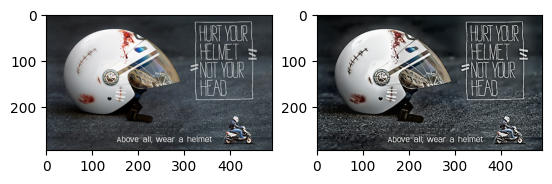

In [5]:
image = cv2.imread('helmet.png')

plt.subplot(1,2,1)
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))

dehazed_image = increase_light_for_streaming(image,reduce=True)

plt.subplot(1,2,2)
plt.imshow(cv2.cvtColor(dehazed_image, cv2.COLOR_BGR2RGB))
plt.show()

In [6]:
path = process_images_in_folder('data_after_annotate//images_night', 'data_after_annotate//images')
print('Images have been processed and saved in folder:', path)

Images have been processed and saved in folder: data_after_annotate//images
